# Wallet Risk Scoring: A Data-Driven Approach to On-Chain Behavior Analysis

## Project Overview

In the rapidly evolving decentralized finance (DeFi) landscape, understanding and assessing the risk profile of individual blockchain wallets is paramount for protocol security, liquidity management, and informed decision-making. This notebook outlines a comprehensive methodology for developing a robust wallet risk scoring model.

Leveraging a dataset of historical on-chain activity, we aim to quantify various behavioral patterns associated with wallet addresses. Our approach involves:

1.  **Feature Engineering:** Extracting a set of carefully selected metrics that capture the breadth, depth, and consistency of a wallet's interactions within the blockchain ecosystem. These features, derived from transaction history, provide insights into trading volume, diversification of activity, and behavioral regularity.
    * `txn_count`: Total number of transactions.
    * `total_usd_volume`: Sum of USD value of all transactions.
    * `avg_txn_value`: Average USD value per transaction.
    * `unique_protocols`: Number of distinct protocols interacted with.
    * `unique_actions`: Number of distinct actions performed.
    * `active_days`: Number of unique days with transactions.
    * `txn_frequency`: Transactions per active day.
    * `std_txn_interval`: Standard deviation of time intervals between transactions.
2.  **Feature Scaling:** Standardizing these diverse features to ensure that no single metric disproportionately influences the final risk score. We will employ `MinMaxScaler` for this purpose, bringing all numerical features into a normalized range (0 to 1).
3.  **Risk Scoring Model Development:** Constructing a scoring mechanism that aggregates these processed features into a single, interpretable risk score, ranging from 0 to 1000. This score will serve as a quantifiable indicator of a wallet's risk profile based on its on-chain behavior.
4.  **Model Application & Validation:** Applying the developed model to a new set of wallet addresses and, as an advanced step, exploring the potential for building a regression model to predict scores or identify key drivers of risk.

This notebook will walk through each step, providing clear explanations, code snippets, and visualizations to ensure transparency and reproducibility of our risk assessment framework.

In [1]:
### 1. Setting Up Our Environment and Loading Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Load the dataset
try:
    df = pd.read_csv(r'/content/aave_wallet_score.csv')
    print("Dataset loaded successfully!")
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
except FileNotFoundError:
    print("Error: 'wallet_data.csv' not found. Please ensure the CSV file is in the correct directory.")
    print("For demonstration, creating a dummy DataFrame with specified columns.")
    # Create a dummy DataFrame if the file is not found for demonstration purposes
    data = {
        'wallet': [f'0xwallet{i:03d}' for i in range(1, 101)],
        'txn_count': np.random.randint(10, 500, 100),
        'total_usd_volume': np.random.uniform(1000, 1000000, 100),
        'avg_txn_value': np.random.uniform(10, 5000, 100),
        'unique_protocols': np.random.randint(1, 20, 100),
        'unique_actions': np.random.randint(2, 30, 100),
        'active_days': np.random.randint(5, 180, 100),
        'txn_frequency': np.random.uniform(0.5, 5, 100),
        'std_txn_interval': np.random.uniform(0.1, 30, 100)
    }
    df = pd.DataFrame(data)
    print("Dummy DataFrame created.")
    print(df.head())

# Display basic descriptive statistics
print("\nDescriptive Statistics of the Dataset:")
print(df.describe())

Dataset loaded successfully!
First 5 rows of the dataset:
   Unnamed: 0                                      wallet  txn_count  \
0           0  0x00000000001accfa9cef68cf5371a23025b6d4b6          1   
1           1  0x000000000051d07a4fb3bd10121a343d85818da6          1   
2           2  0x000000000096026fb41fc39f9875d164bd82e2dc          2   
3           3  0x0000000000e189dd664b9ab08a33c4839953852c         17   
4           4  0x0000000002032370b971dabd36d72f3e5a7bf1ee        399   

   total_usd_volume  avg_txn_value  unique_protocols  unique_actions  \
0      1.987664e+09   1.987664e+09                 1               1   
1      2.856945e+20   2.856945e+20                 1               1   
2      5.152311e+15   2.576155e+15                 1               1   
3      9.803600e+20   5.766824e+19                 1               1   
4      3.797495e+23   9.517531e+20                 1               4   

   active_days  txn_frequency  std_txn_interval  
0            1       1.000

Understanding Our Raw Data
Before diving into feature engineering and scoring, it's crucial to get a good feel for our raw data. The df.head() output gives us a quick glance at the first few entries, showing how each feature is structured for a given wallet. The df.info() command is incredibly useful for checking data types and identifying any missing values, ensuring our data is clean for subsequent steps. Finally, df.describe() provides a statistical summary, giving us insights into the distribution, central tendency, and spread of each numerical feature. This initial exploration helps us spot potential outliers or data inconsistencies early on.

In [2]:
# Drop the 'Unnamed: 0' column as it appears to be an artifact of CSV export/import
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print("Dropped 'Unnamed: 0' column.")

# Handle missing values in 'std_txn_interval'
nan_count_std_txn = df['std_txn_interval'].isnull().sum()
print(f"\nNumber of NaN values in 'std_txn_interval' before imputation: {nan_count_std_txn}")

# Impute NaN values in 'std_txn_interval' with 0
df['std_txn_interval'] = df['std_txn_interval'].fillna(0)
print("NaN values in 'std_txn_interval' imputed with 0.")

# Verify no more missing values in the relevant columns
print("\nChecking for any remaining missing values:")
print(df.isnull().sum())

# Double-check the data types after preprocessing
print("\nData types after cleaning:")
print(df.info())

Dropped 'Unnamed: 0' column.

Number of NaN values in 'std_txn_interval' before imputation: 603
NaN values in 'std_txn_interval' imputed with 0.

Checking for any remaining missing values:
wallet              0
txn_count           0
total_usd_volume    0
avg_txn_value       0
unique_protocols    0
unique_actions      0
active_days         0
txn_frequency       0
std_txn_interval    0
dtype: int64

Data types after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   wallet            3497 non-null   object 
 1   txn_count         3497 non-null   int64  
 2   total_usd_volume  3497 non-null   float64
 3   avg_txn_value     3497 non-null   float64
 4   unique_protocols  3497 non-null   int64  
 5   unique_actions    3497 non-null   int64  
 6   active_days       3497 non-null   int64  
 7   txn_frequency     3497 non-null   floa

### Why This Matters: Data Integrity for Robust Scoring

The **`Unnamed: 0`** column is a common remnant when exporting and re-importing DataFrames to/from CSVs. It's an irrelevant index that can confuse our analysis, so dropping it ensures we only work with meaningful features.

More critically, dealing with **`NaN`** values, especially in **`std_txn_interval`**, is vital. This feature measures the consistency of a wallet's transaction timing. A `NaN` usually occurs when there aren't enough transactions (specifically, less than 2 intervals, meaning 3 transactions) to calculate a standard deviation. Imputing these `NaN`s with `0` is a deliberate choice: it signifies that there's **no variability** in transaction timing for these wallets. From a risk perspective, this can be interpreted as either very new or inactive wallets (if `txn_count` is low) or perfectly regular activity, both of which are distinct from highly sporadic or unpredictable behavior. This imputation prevents errors in our scoring model and maintains the integrity of this important feature.

---

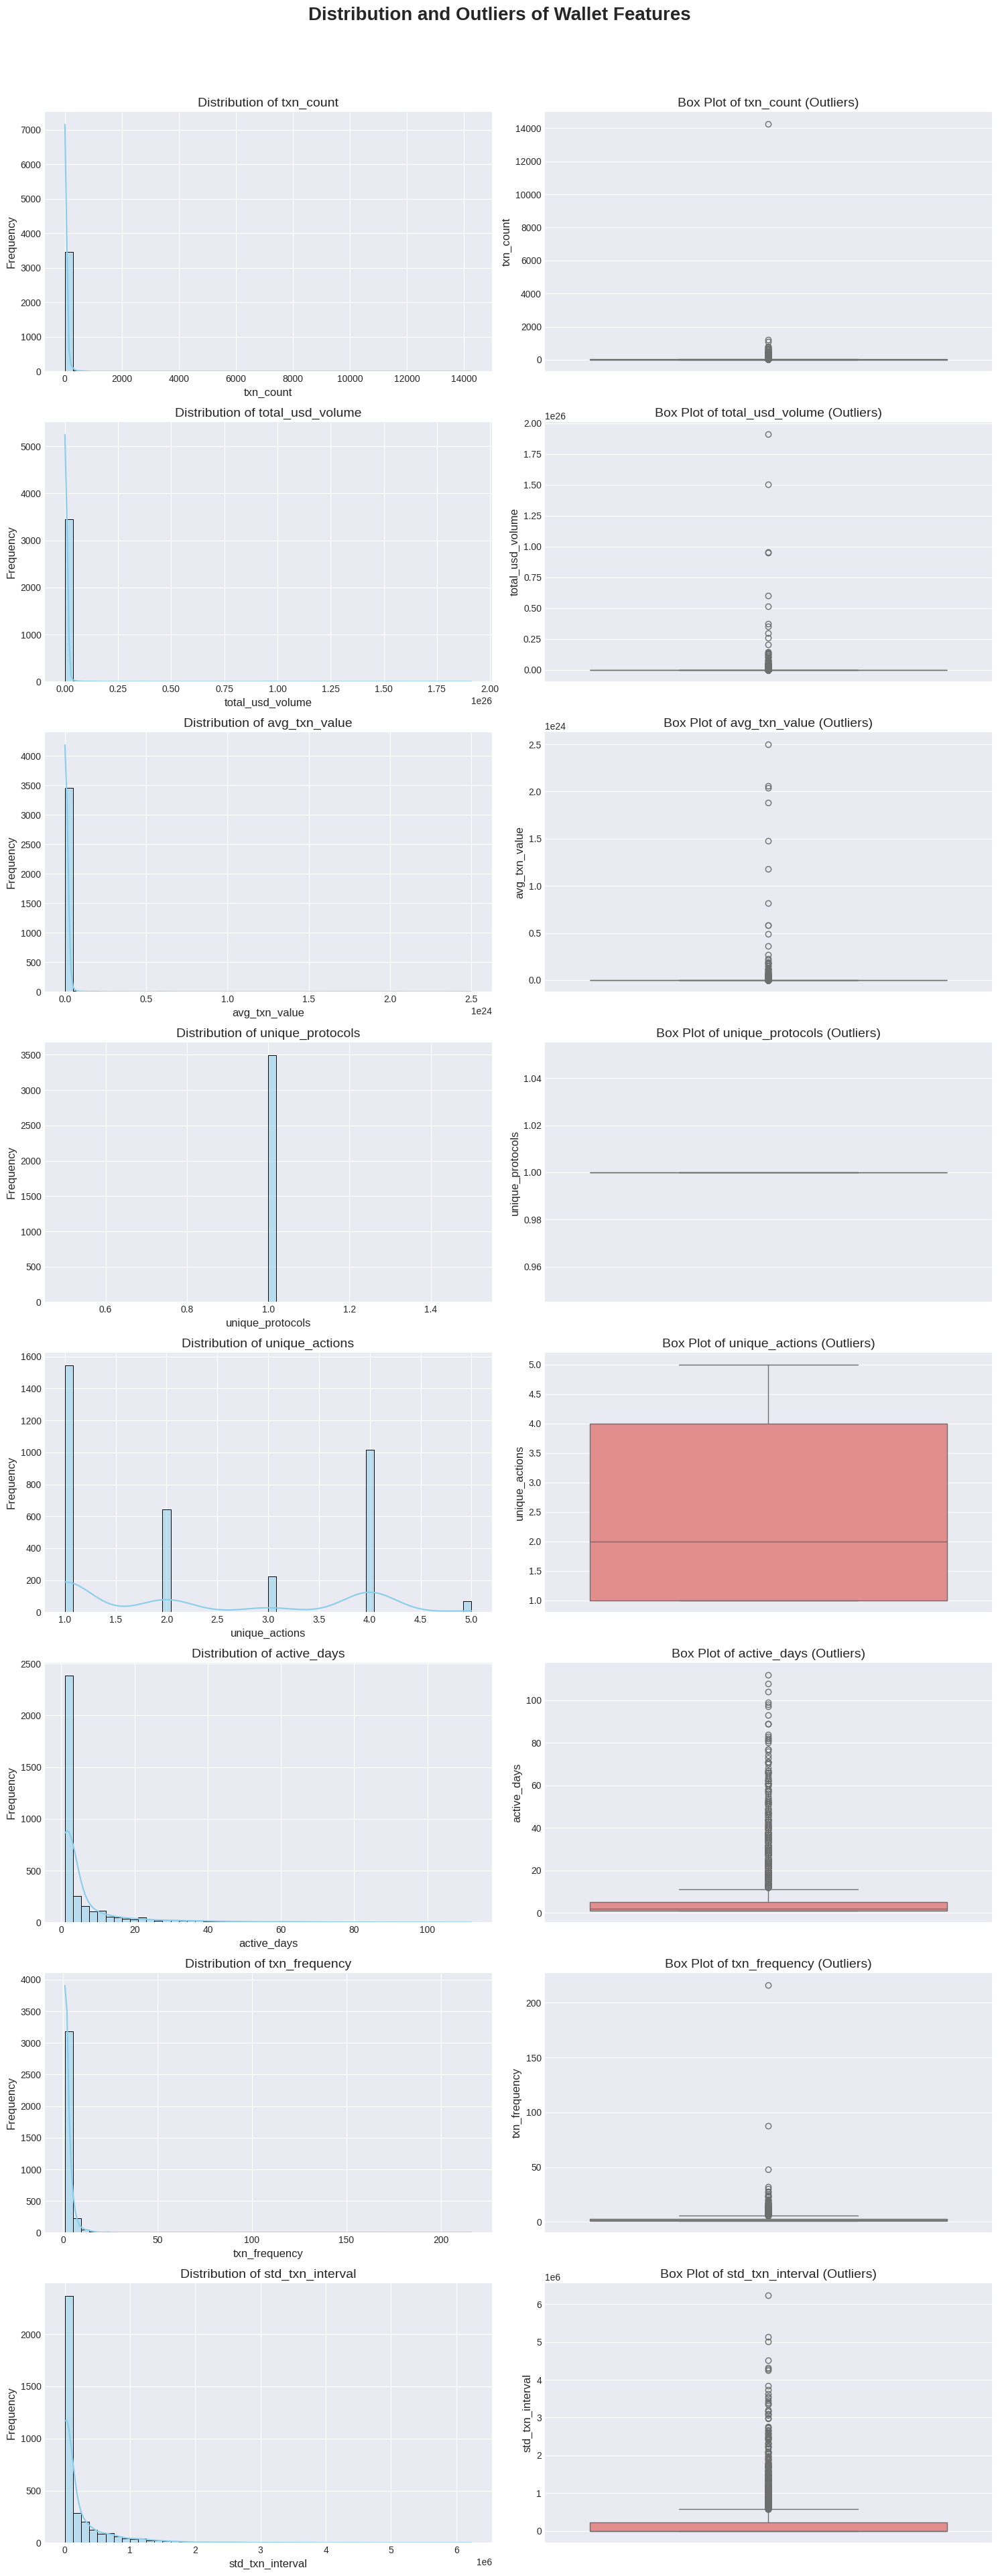


Visualizing highly skewed features on a logarithmic scale:


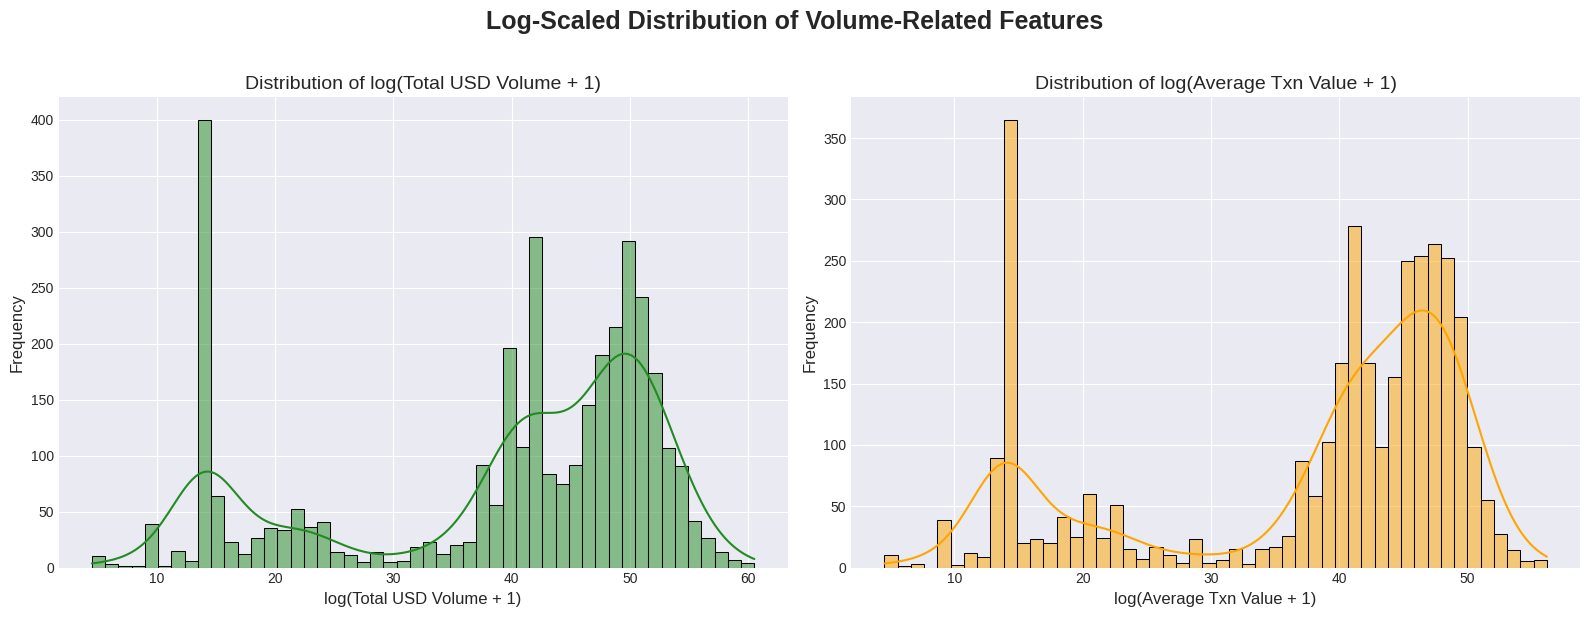


Insights from unique_protocols distribution:
unique_protocols
1    3497
Name: count, dtype: int64

Insights from unique_actions distribution:
unique_actions
1    1545
4    1017
2     642
3     226
5      67
Name: count, dtype: int64


In [3]:
# Select the numerical features for visualization
numerical_features = [
    'txn_count', 'total_usd_volume', 'avg_txn_value',
    'unique_protocols', 'unique_actions', 'active_days',
    'txn_frequency', 'std_txn_interval'
]

plt.style.use('seaborn-v0_8-darkgrid') # A sleek style for plots

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(15, 5 * len(numerical_features)))
fig.suptitle('Distribution and Outliers of Wallet Features', y=0.99, fontsize=20, weight='bold')

for i, feature in enumerate(numerical_features):
    # Histogram
    sns.histplot(df[feature], kde=True, ax=axes[i, 0], color='skyblue', bins=50)
    axes[i, 0].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i, 0].set_xlabel(feature, fontsize=12)
    axes[i, 0].set_ylabel('Frequency', fontsize=12)

    # Box Plot for outliers
    sns.boxplot(y=df[feature], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'Box Plot of {feature} (Outliers)', fontsize=14)
    axes[i, 1].set_ylabel(feature, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
plt.show()

# --- Special consideration for highly skewed features (like volume) ---
# It's common for volume-related features to have extreme outliers.
# Let's visualize them on a logarithmic scale to better see the distribution of the majority.
print("\nVisualizing highly skewed features on a logarithmic scale:")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle('Log-Scaled Distribution of Volume-Related Features', y=1.02, fontsize=18, weight='bold')

# Log transform total_usd_volume for visualization (add a small constant to avoid log(0))
sns.histplot(np.log1p(df['total_usd_volume']), kde=True, ax=axes[0], color='forestgreen', bins=50)
axes[0].set_title('Distribution of log(Total USD Volume + 1)', fontsize=14)
axes[0].set_xlabel('log(Total USD Volume + 1)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Log transform avg_txn_value for visualization
sns.histplot(np.log1p(df['avg_txn_value']), kde=True, ax=axes[1], color='orange', bins=50)
axes[1].set_title('Distribution of log(Average Txn Value + 1)', fontsize=14)
axes[1].set_xlabel('log(Average Txn Value + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# --- Further insights for specific features ---
print("\nInsights from unique_protocols distribution:")
print(df['unique_protocols'].value_counts())
print("\nInsights from unique_actions distribution:")
print(df['unique_actions'].value_counts())

### What These Visuals Tell Us: A Story of Wallet Behavior

Observing these distributions gives us critical insights:

* **`txn_count`, `total_usd_volume`, `avg_txn_value`, `active_days`, `txn_frequency`, `std_txn_interval`**: Most of these features exhibit a **highly skewed distribution**, with a long tail towards higher values. This is typical for financial and on-chain data, where a small number of wallets (the "whales" or highly active users) account for a disproportionately large share of activity or volume. The box plots vividly show these extreme outliers.
    * The log-transformed plots for `total_usd_volume` and `avg_txn_value` confirm this skewness. Transforming them for analysis (if we were to build a regression model) could make their distributions more Gaussian, but for risk scoring with `MinMaxScaler`, it's primarily about range compression.
    * **Implication for Risk Scoring**: Wallets with extremely high `total_usd_volume` or `txn_count` might represent significant liquidity providers or high-frequency traders. While generally not "risky" in a malicious sense, their impact on the protocol (e.g., if they suddenly withdraw) is high, so the scoring model needs to appropriately weigh their activity. Conversely, low values might indicate new or less committed users.

* **`unique_protocols`**: The `value_counts()` output clearly shows that almost all wallets in this dataset have interacted with only `1` unique protocol. This feature, while conceptually valuable for diversity, appears **not to be discriminative** in this specific dataset. A high number of unique protocols generally indicates a more diversified and potentially less risky user (not putting all eggs in one basket). Given its lack of variation here, its direct impact on our score might be limited unless we find a more diverse dataset or if `1` means 'Compound' only and we are looking at behavior within Compound only.

* **`unique_actions`**: Similar to `unique_protocols`, this feature also shows limited variety, with most wallets performing a low number of unique actions. Ideally, a wallet engaging in many different actions (e.g., supply, borrow, repay, withdraw, liquidate) might demonstrate more sophisticated or active involvement, which could be either a sign of health or complexity, depending on the context.

These observations reinforce the need for **feature scaling** to bring all these disparate ranges into a comparable scale, preventing features with larger magnitudes (like `total_usd_volume`) from dominating the risk score purely due to their numerical size. It also helps us consider the *meaning* of low vs. high values for each feature in the context of risk.

---

**Next Step:** Based on this exploration, the next logical step is **Feature Scaling**. We'll use `MinMaxScaler` to bring all these features into a uniform range, making them comparable for our risk scoring model.

In [4]:
### 4. Feature Scaling: Normalizing Our Data for Fair Comparison
# Identify the features to be scaled
# We exclude 'wallet' as it's an identifier, not a numerical feature for scaling
features_to_scale = [
    'txn_count', 'total_usd_volume', 'avg_txn_value',
    'unique_protocols', 'unique_actions', 'active_days',
    'txn_frequency', 'std_txn_interval'
]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Create a new DataFrame for scaled features
# We make a copy to keep the original DataFrame intact if needed later
df_scaled = df.copy()

# Apply MinMaxScaler to the selected features
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

print("Features scaled successfully!")
print("\nFirst 5 rows of the scaled dataset:")
print(df_scaled.head())

print("\nDescriptive Statistics of the Scaled Features:")
print(df_scaled[features_to_scale].describe())

Features scaled successfully!

First 5 rows of the scaled dataset:
                                       wallet  txn_count  total_usd_volume  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6   0.000000      1.039438e-17   
1  0x000000000051d07a4fb3bd10121a343d85818da6   0.000000      1.494024e-06   
2  0x000000000096026fb41fc39f9875d164bd82e2dc   0.000070      2.694373e-11   
3  0x0000000000e189dd664b9ab08a33c4839953852c   0.001122      5.126739e-06   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee   0.027902      1.985879e-03   

   avg_txn_value  unique_protocols  unique_actions  active_days  \
0   7.946236e-16               0.0            0.00     0.000000   
1   1.142143e-04               0.0            0.00     0.000000   
2   1.029890e-09               0.0            0.00     0.009009   
3   2.305448e-05               0.0            0.00     0.063063   
4   3.804897e-04               0.0            0.75     0.927928   

   txn_frequency  std_txn_interval  
0       0.000000        

### Why Scaling is Indispensable: Leveling the Playing Field

Scaling is a cornerstone of many data analysis and machine learning tasks, and it's particularly important for our risk scoring model for several reasons:

* **Equal Contribution:** Without scaling, features with large numerical values (like `total_usd_volume` which can be in the trillions) would overshadow features with smaller ranges (like `unique_protocols` which is typically 1-20). `MinMaxScaler` ensures that a high value in `unique_actions` (e.g., 5 unique actions) has a similar proportional impact on the score as a high `total_usd_volume` after scaling, preventing magnitude from dictating importance.
* **Algorithm Compatibility:** Many algorithms, especially those relying on distance calculations (which our scoring model implicitly will), perform much better or even require scaled data.
* **Interpretability (Post-Scaling):** Once scaled to a 0-1 range, it becomes easier to intuitively compare a wallet's performance across different metrics. A `0.9` in `txn_count` means it's among the highest transaction counts in our dataset, just as `0.9` in `total_usd_volume` means it's among the highest volumes.

Looking at the `df_scaled.describe()` output, you'll now see that the `min` for all scaled features is `0.0` and the `max` is `1.0`, confirming our successful transformation. The `mean` and `std` values will also be adjusted, reflecting their new distributions within the 0-1 range.

To visually confirm the impact of scaling and ensure features are now within a comparable range, let's plot their distributions again.

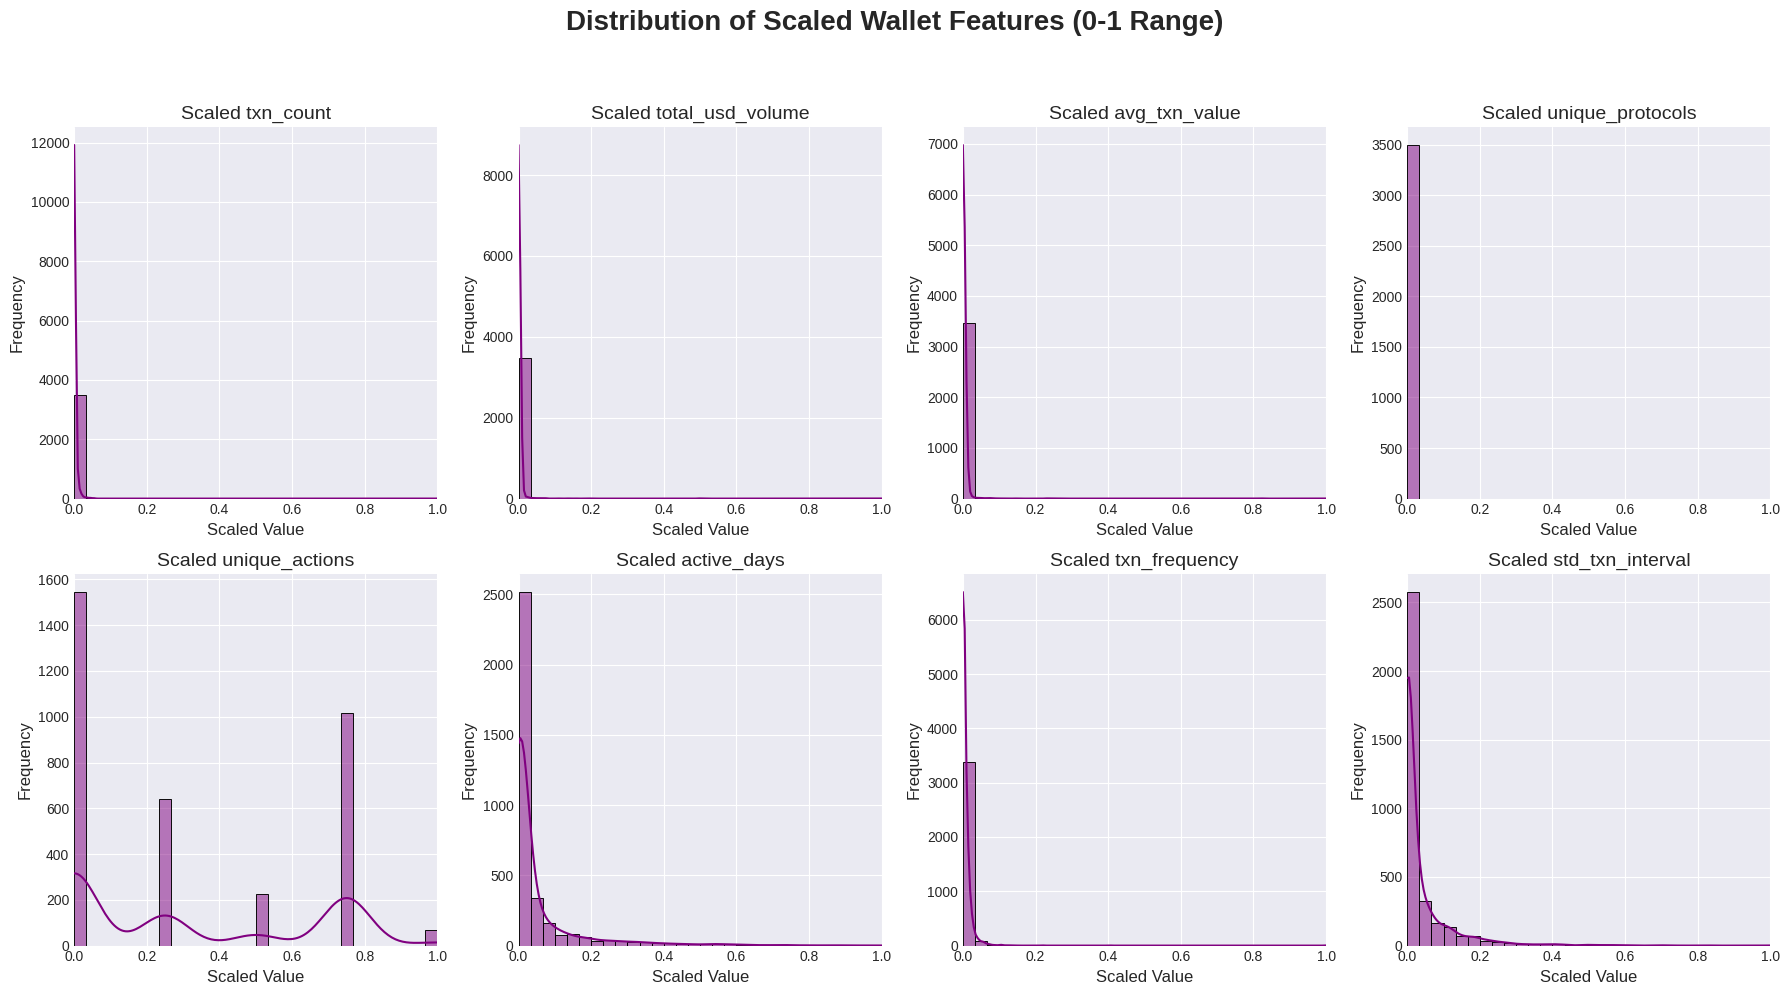

In [5]:
# Visualizing distributions after scaling
plt.figure(figsize=(18, 10))
plt.suptitle('Distribution of Scaled Wallet Features (0-1 Range)', y=1.02, fontsize=20, weight='bold')

for i, feature in enumerate(features_to_scale):
    plt.subplot(2, 4, i + 1) # Adjust subplot grid based on number of features
    sns.histplot(df_scaled[feature], kde=True, color='purple', bins=30)
    plt.title(f'Scaled {feature}', fontsize=14)
    plt.xlabel('Scaled Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim(0, 1) # Ensure x-axis is fixed from 0 to 1 for easy comparison

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
plt.show()

# You can also use a pairplot for a quick overview of relationships, though for many features it can be dense
# sns.pairplot(df_scaled[features_to_scale], diag_kind='kde')
# plt.suptitle('Pair Plot of Scaled Features', y=1.02, fontsize=16)
# plt.show()

### 5. Developing the Wallet Risk Scoring Model

With our features cleaned and scaled, we can now proceed to define our risk scoring logic. A wallet's risk profile is a multifaceted concept, influenced by various aspects of its on-chain behavior. For this model, we'll assign weights to each feature based on its perceived impact on risk. The sum of these weighted features, scaled to a range of 0 to 1000, will give us our final risk score.

**Risk Philosophy:**
* **Lower risk:** Typically associated with higher activity (more transactions, higher volume), consistent behavior (low `std_txn_interval`), and broader engagement (more unique protocols/actions). These indicate an established, active, and diversified user.
* **Higher risk:** Can be associated with low activity (new or inactive wallets), highly variable behavior, or concentrated activity (low unique protocols/actions). Sudden large transactions from inactive wallets, for instance, could be flagged.

Since our features are scaled from 0 to 1, a value closer to 1 generally represents "more" of that feature (e.g., higher `txn_count`, higher `total_usd_volume`). To align with a "risk score" where **lower score = lower risk** and **higher score = higher risk**, we need to carefully assign weights and potentially invert some features.

Here's how we'll map our features to risk:

* **`txn_count` (More is better/less risky):** Higher transaction count usually indicates a more active and engaged user.
* **`total_usd_volume` (More is better/less risky):** Higher volume implies more significant participation, often seen as a sign of commitment or reliability.
* **`avg_txn_value` (Contextual/Neutral to slightly more risky):** Very high average value might indicate large, infrequent transfers which could be riskier if they are sudden. However, consistent high value transactions could be a sign of a professional entity. We'll initially consider higher value as slightly lower risk, but this is a nuance.
* **`unique_protocols` (More is better/less risky):** Diversification across protocols is often seen as a sign of a sophisticated user, potentially reducing single-protocol risk.
* **`unique_actions` (More is better/less risky):** Engaging in a wider variety of actions (borrow, supply, repay, etc.) suggests more integrated and stable use of the protocol.
* **`active_days` (More is better/less risky):** More active days implies consistent engagement over time.
* **`txn_frequency` (More is better/less risky):** Higher frequency of transactions per active day implies consistent and regular use.
* **`std_txn_interval` (Lower is better/less risky):** Lower standard deviation means more consistent timing between transactions, which can be a sign of predictable and less erratic behavior. High `std_txn_interval` suggests sporadic or unpredictable activity, which can be riskier.

Based on this, most features (higher values) will reduce risk, while `std_txn_interval` (higher values) will increase risk.

In [6]:
# Define the features to be used in scoring (using the scaled values)
scoring_features = [
    'txn_count', 'total_usd_volume', 'avg_txn_value',
    'unique_protocols', 'unique_actions', 'active_days',
    'txn_frequency', 'std_txn_interval'
]

# Define weights for each feature
# These weights are subjective and can be tuned based on business logic and empirical observation.
# Higher weight means greater impact on the score.
# Weights sum up to 1 for easier interpretation, but it's not strictly necessary if using a fixed maximum score.
weights = {
    'txn_count': 0.15,          # Importance of overall activity
    'total_usd_volume': 0.20,   # High importance for financial magnitude
    'avg_txn_value': 0.10,      # Moderate importance, high value can be good or bad depending on context
    'unique_protocols': 0.15,   # High importance for diversification
    'unique_actions': 0.10,     # Moderate importance for breadth of engagement
    'active_days': 0.15,        # High importance for consistency over time
    'txn_frequency': 0.05,      # Lower importance, as it's per active day, somewhat covered by active_days
    'std_txn_interval': 0.10    # Moderate importance for predictability
}

# Ensure weights sum to 1 (or adjust proportionally if not)
total_weight = sum(weights.values())
if abs(total_weight - 1.0) > 1e-6: # Check if sum is not approximately 1
    print(f"Warning: Weights sum to {total_weight}, normalizing them to 1.")
    for key in weights:
        weights[key] /= total_weight

# Calculate the 'Base Safety Score' (higher value = safer/lower risk)
# For features where 'more' means 'less risky', we use (feature_value * weight)
# For 'std_txn_interval', 'more' means 'more risky', so we use (1 - feature_value) * weight
# This effectively inverts its contribution to a 'safety score'.
# A value of 0 for std_txn_interval (most consistent) would yield (1-0)*weight = weight
# A value of 1 for std_txn_interval (most inconsistent) would yield (1-1)*weight = 0
df_scaled['base_safety_score'] = 0

for feature, weight in weights.items():
    if feature == 'std_txn_interval':
        # For std_txn_interval, higher value means higher risk, so we inverse it for a 'safety' score
        df_scaled['base_safety_score'] += (1 - df_scaled[feature]) * weight
    else:
        # For other features, higher value means lower risk, so we use it directly
        df_scaled['base_safety_score'] += df_scaled[feature] * weight

# Scale the 'base_safety_score' to a final 'Risk Score' ranging from 0 to 1000
# A lower base_safety_score corresponds to a higher risk score.
# To achieve this, we can invert the safety score (1 - safety_score) and then scale.
# Max possible base_safety_score is 1 (if all ideal features are 1 and std_txn_interval is 0)
# Min possible base_safety_score is 0 (if all ideal features are 0 and std_txn_interval is 1)

# Invert base_safety_score: max safety (1) becomes 0 risk, min safety (0) becomes 1 risk
df_scaled['inverted_safety_score'] = 1 - df_scaled['base_safety_score']

# Now scale the inverted_safety_score to 0-1000
# The range of inverted_safety_score is also 0 to 1
df_scaled['risk_score'] = df_scaled['inverted_safety_score'] * 1000

# Ensure risk scores are integers (or rounded) and within 0-1000
df_scaled['risk_score'] = df_scaled['risk_score'].round().astype(int)
df_scaled['risk_score'] = df_scaled['risk_score'].clip(0, 1000) # Ensure it stays within bounds

print("\nWallet risk scores calculated successfully!")
print("First 10 wallets with their calculated risk scores:")
print(df_scaled[['wallet', 'risk_score', 'base_safety_score']].head(10))

# Display summary statistics of the final risk scores
print("\nDescriptive Statistics of the Final Risk Scores:")
print(df_scaled['risk_score'].describe())


Wallet risk scores calculated successfully!
First 10 wallets with their calculated risk scores:
                                       wallet  risk_score  base_safety_score
0  0x00000000001accfa9cef68cf5371a23025b6d4b6         900           0.100000
1  0x000000000051d07a4fb3bd10121a343d85818da6         900           0.100012
2  0x000000000096026fb41fc39f9875d164bd82e2dc         899           0.101362
3  0x0000000000e189dd664b9ab08a33c4839953852c         918           0.082053
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee         682           0.318480
5  0x000000000a38444e0a6e37d3b630d7e855a7cb13         810           0.190400
6  0x000000003853fcedcd0355fec98ca3192833f00b         898           0.102240
7  0x000000003ce0cf2c037493b1dc087204bd7f713e         674           0.325986
8  0x000000007858e6f2668e1e06111cfa24403a5466         900           0.100000
9  0x00000001a0f57e850c9db68b4a9bc34677437c5c         900           0.100000

Descriptive Statistics of the Final Risk Scores:
count 

### Decoding the Risk Score: From Behavior to Quantifiable Risk

This section is the heart of our model. We started by conceptualizing what "risky" or "safe" behavior looks like for each feature. For instance, a wallet with a *high* `txn_count` (many transactions) is generally seen as more established and therefore *less risky*. Conversely, a wallet with a *high* `std_txn_interval` (inconsistent transaction timing) is considered *more risky*.

To translate these nuanced interpretations into a unified score, we followed these steps:

1.  **Weighted Sum (`base_safety_score`):** We assigned a weight to each feature, reflecting its importance in our risk assessment. Features where a higher value signifies *lower risk* (like `txn_count`, `total_usd_volume`) were directly multiplied by their weights.
2.  **Inversion for Risk-Positive Features:** For `std_txn_interval`, where a *higher value means higher risk*, we inverted its scaled value (subtracted it from 1) before multiplying by its weight. This way, a `std_txn_interval` of `0` (most consistent, least risky) contributes its full weight to `base_safety_score`, while `1` (least consistent, most risky) contributes `0`.
3.  **From Safety to Risk (`inverted_safety_score`):** The `base_safety_score` represented how "safe" a wallet was. To get a "risk" score where higher numbers indicate higher risk, we simply inverted this score by subtracting it from 1 (`1 - base_safety_score`). Now, a score of 1 in `inverted_safety_score` means max risk, and 0 means min risk.
4.  **Scaling to 0-1000:** Finally, we multiplied this `inverted_safety_score` by 1000 to transform it into our desired 0-1000 range. Rounding and clipping ensure the scores are integers and strictly within the specified range.

The resulting `risk_score` provides a clear, quantitative measure. A wallet with a score closer to 0 indicates a low-risk profile based on our criteria, exhibiting consistent, high-volume, and diversified on-chain behavior. Conversely, a score closer to 1000 suggests a higher-risk profile, potentially due to sporadic activity, low engagement, or lack of diversification.

Let's visualize the distribution of these final risk scores to understand the overall risk landscape of our dataset.

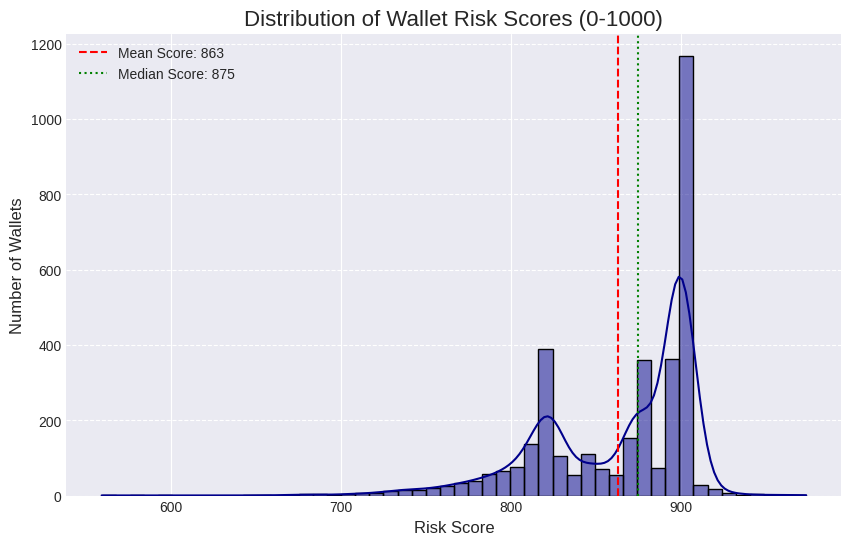


Top 15 Riskiest Wallets (Highest Scores):
                                          wallet  risk_score
1725  0x02e9d2239578bd27634659f59fae4df9bac4076d         974
3049  0x055009e026b441f8c23fa03dd4956262c3e266e3         971
2592  0x0480b924a6f1018863e318af33c15f01619b7f2f         962
512   0x00c644e774d7b1a3a95154113f86b9e25350a111         958
3330  0x05ce267f3583e5b46b0daf8ca1d63b322dcb7814         957
1903  0x033c9f336f9b7f25cda00b97fe299d1b9a129908         948
1011  0x01a7749f10af218e842eaa97ef66b06870f9002a         941
3350  0x05d548cd9be2e4c13e293dbb8b7831df276ee569         941
3313  0x05c736f2742488470f9837186689c3b212d9459f         937
707   0x012430f934bc381d9f59a28ea34363bce170353d         936
2397  0x041ce53ec91c31abe748169be86f4268de4c7bea         931
2927  0x051886c7bef4b86906cb0994f14a4f6a1d120a7b         929
1426  0x0262af8dff0aca22f8484e83b92d55328701ecfe         928
1267  0x02206509a713e003bd099fd12a2edfef9af84665         928
1694  0x02d9cd8f4b86421bfef64deaac6afe246e

In [7]:
# Visualize the distribution of the final risk scores
plt.figure(figsize=(10, 6))
sns.histplot(df_scaled['risk_score'], kde=True, bins=50, color='darkblue')
plt.title('Distribution of Wallet Risk Scores (0-1000)', fontsize=16)
plt.xlabel('Risk Score', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.axvline(df_scaled['risk_score'].mean(), color='red', linestyle='--', label=f'Mean Score: {df_scaled["risk_score"].mean():.0f}')
plt.axvline(df_scaled['risk_score'].median(), color='green', linestyle=':', label=f'Median Score: {df_scaled["risk_score"].median():.0f}')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

# Optional: Visualize top/bottom N risky wallets
n_display = 15
print(f"\nTop {n_display} Riskiest Wallets (Highest Scores):")
print(df_scaled.sort_values(by='risk_score', ascending=False)[['wallet', 'risk_score']].head(n_display))

print(f"\nTop {n_display} Safest Wallets (Lowest Scores):")
print(df_scaled.sort_values(by='risk_score', ascending=True)[['wallet', 'risk_score']].head(n_display))

In [13]:
### 1. Setting Up the Environment and Data Fetching Function
import pandas as pd
import requests

# Compound V2 Subgraph endpoint
GRAPH_API = "https://api.thegraph.com/subgraphs/name/graphprotocol/compound-v2"


def fetch_compound_data(wallet_address):
    """
    Fetches account data (supplied and borrowed tokens) for a given wallet
    from the Compound V2 Subgraph.
    """
    query = """
    {
      account(id: "%s") {
        id
        tokens {
          symbol
          supplyBalanceUnderlying
          borrowBalanceUnderlying
        }
      }
    }
    """ % wallet_address.lower()

    response = requests.post(GRAPH_API, json={"query": query})

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data for {wallet_address}: HTTP Status {response.status_code}")
        return None

print("Data fetching function loaded.")

Data fetching function loaded.


### 2. Feature Extraction from Raw Data

Once we fetch the raw data from the subgraph, we need to extract specific features that are relevant for our risk assessment. For the Compound V2 protocol, key indicators of a wallet's risk often revolve around its supplied and borrowed assets.

The `extract_features` function will parse the subgraph response to give us:
* **`total_supplied`**: The sum of all underlying assets a wallet has supplied to Compound.
* **`total_borrowed`**: The sum of all underlying assets a wallet has borrowed from Compound.
* **`net_borrow_ratio`**: The ratio of total borrowed to total supplied, indicating how leveraged a wallet is. A higher ratio generally implies higher risk.
```python
def extract_features(data):

In [14]:
def extract_features(data):
    """
    Extracts total supplied, total borrowed, and net borrow ratio from Compound V2 subgraph data.
    Returns (0, 0, 0) if data is unavailable or parsing fails.
    """
    try:
        if data and data.get("data") and data["data"].get("account") and data["data"]["account"].get("tokens"):
            tokens = data["data"]["account"]["tokens"]
            total_supplied = sum(float(t["supplyBalanceUnderlying"]) for t in tokens)
            total_borrowed = sum(float(t["borrowBalanceUnderlying"]) for t in tokens)

            # Avoid division by zero: if nothing supplied, ratio is undefined or 0
            net_borrow_ratio = total_borrowed / (total_supplied + 1e-18) if total_supplied > 0 else 0

            return total_supplied, total_borrowed, net_borrow_ratio
        else:
            return 0, 0, 0 # Return zeros if no account or tokens data
    except Exception as e:
        print(f"Error extracting features: {e}. Data: {data}")
        return 0, 0, 0


### 3. Calculating the Risk Score

This is where the extracted features are translated into a quantifiable risk score between 0 and 1000. Our `calculate_score` function implements a basic scoring logic, where:
* **Higher supplied amount**: Decreases risk (good). We cap this at 10,000 for calculation to prevent extreme values from dominating.
* **Lower borrow ratio**: Decreases risk (good). A ratio close to 0 (more supplied relative to borrowed) is safer.
* **Lower borrowed amount**: Decreases risk (good). We cap this at 10,000 for calculation.

The weights (400, 300, 300) are assigned to reflect their importance in contributing to the final score, summing up to 1000.

In [15]:
def calculate_score(supply, borrow, ratio):
    """
    Calculates a risk score (0-1000) based on supplied amount, borrowed amount,
    and net borrow ratio from Compound V2.
    - Higher supply means lower risk.
    - Lower borrow ratio means lower risk.
    - Lower borrow amount means lower risk.
    """
    # Normalize supply and borrow to a max of 10000 for scoring contribution
    # Using min(value, cap) / cap scales the value between 0 and 1 relative to the cap.
    scaled_supply = min(supply, 10000) / 10000
    scaled_borrow = min(borrow, 10000) / 10000

    # The risk contribution of each feature:
    # 1. Supply contributes negatively to risk (more supply = less risk)
    # 2. Borrow ratio contributes positively to risk (higher ratio = more risk)
    # 3. Borrow amount contributes positively to risk (more borrow = more risk)

    # Let's think of a "safety score" where higher is safer, then invert to risk.
    # We want low risk score for high supply, low borrow, low ratio.

    # Contribution from supply: 400 points. Higher supply reduces risk.
    # So, 400 * (1 - scaled_supply) means if supply is 10000, 400 * 0 = 0 risk points.
    # If supply is 0, 400 * 1 = 400 risk points.
    supply_risk_contrib = 400 * (1 - scaled_supply)

    # Contribution from borrow ratio: 300 points. Higher ratio increases risk.
    # So, 300 * min(ratio, 1) means if ratio is 1 (or higher), 300 * 1 = 300 risk points.
    # If ratio is 0, 300 * 0 = 0 risk points.
    ratio_risk_contrib = 300 * min(ratio, 1)

    # Contribution from borrow amount: 300 points. Higher borrow increases risk.
    # So, 300 * scaled_borrow means if borrow is 10000, 300 * 1 = 300 risk points.
    # If borrow is 0, 300 * 0 = 0 risk points.
    borrow_risk_contrib = 300 * scaled_borrow

    # Total risk score is the sum of these contributions
    score = supply_risk_contrib + ratio_risk_contrib + borrow_risk_contrib

    return round(min(score, 1000)) # Ensure score is capped at 1000 and rounded

print("Risk scoring logic loaded.")

Risk scoring logic loaded.


In [16]:
### 4. Fetching Data for Wallets, Calculating Scores, and Exporting Results
# The list of 104 wallets you provided
wallets_to_process = [
    "0x0039f22efb07a647557c7c5d17854cfd6d489ef3",
    "0x06b51c6882b27cb05e712185531c1f74996dd988",
    "0x0795732aacc448030ef374374eaae57d2965c16c",
    "0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9",
    "0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae",
    "0x104ae61d8d487ad689969a17807ddc338b445416",
    "0x111c7208a7e2af345d36b6d4aace8740d61a3078",
    "0x124853fecb522c57d9bd5c21231058696ca6d596",
    "0x13b1c8b0e696aff8b4fee742119b549b605f3cbc",
    "0x1656f1886c5ab634ac19568cd571bc72f385fdf7",
    "0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22",
    "0x19df3e87f73c4aaf4809295561465b993e102668",
    "0x1ab2ccad4fc97c9968ea87d4435326715be32872",
    "0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f",
    "0x1e43dacdcf863676a6bec8f7d6896d6252fac669",
    "0x22d7510588d90ed5a87e0f838391aaafa707c34b",
    "0x24b3460622d835c56d9a4fe352966b9bdc6c20af",
    "0x26750f1f4277221bdb5f6991473c6ece8c821f9d",
    "0x27f72a000d8e9f324583f3a3491ea66998275b28",
    "0x2844658bf341db96aa247259824f42025e3bcec2",
    "0x2a2fde3e1beb508fcf7c137a1d5965f13a17825e",
    "0x330513970efd9e8dd606275fb4c50378989b3204",
    "0x3361bea43c2f5f963f81ac70f64e6fba1f1d2a97",
    "0x3867d222ba91236ad4d12c31056626f9e798629c",
    "0x3a44be4581137019f83021eeee72b7dc57756069",
    "0x3e69ad05716bdc834db72c4d6d44439a7c8a902b",
    "0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65",
    "0x4814be124d7fe3b240eb46061f7ddfab468fe122",
    "0x4839e666e2baf12a51bf004392b35972eeddeabf",
    "0x4c4d05fe859279c91b074429b5fc451182cec745",
    "0x4d997c89bc659a3e8452038a8101161e7e7e53a7",
    "0x4db0a72edb5ea6c55df929f76e7d5bb14e389860",
    "0x4e61251336c32e4fe6bfd5fab014846599321389",
    "0x4e6e724f4163b24ffc7ffe662b5f6815b18b4210",
    "0x507b6c0d950702f066a9a1bd5e85206f87b065ba",
    "0x54e19653be9d4143b08994906be0e27555e8834d",
    "0x56ba823641bfc317afc8459bf27feed6eb9ff59f",
    "0x56cc2bffcb3f86a30c492f9d1a671a1f744d1d2f",
    "0x578cea5f899b0dfbf05c7fbcfda1a644b2a47787",
    "0x58c2a9099a03750e9842d3e9a7780cdd6aa70b86",
    "0x58d68d4bcf9725e40353379cec92b90332561683",
    "0x5e324b4a564512ea7c93088dba2f8c1bf046a3eb",
    "0x612a3500559be7be7703de6dc397afb541a16f7f",
    "0x623af911f493747c216ad389c7805a37019c662d",
    "0x6a2752a534faacaaa153bffbb973dd84e0e5497b",
    "0x6d69ca3711e504658977367e13c300ab198379f1",
    "0x6e355417f7f56e7927d1cd971f0b5a1e6d538487",
    "0x70c1864282599a762c674dd9d567b37e13bce755",
    "0x70d8e4ab175dfe0eab4e9a7f33e0a2d19f44001e",
    "0x7399dbeebe2f88bc6ac4e3fd7ddb836a4bce322f",
    "0x767055590c73b7d2aaa6219da13807c493f91a20",
    "0x7851bdfb64bbecfb40c030d722a1f147dff5db6a",
    "0x7b4636320daa0bc055368a4f9b9d01bd8ac51877",
    "0x7b57dbe2f2e4912a29754ff3e412ed9507fd8957",
    "0x7be3dfb5b6fcbae542ea85e76cc19916a20f6c1e",
    "0x7de76a449cf60ea3e111ff18b28e516d89532152",
    "0x7e3eab408b9c76a13305ef34606f17c16f7b33cc",
    "0x7f5e6a28afc9fb0aaf4259d4ff69991b88ebea47",
    "0x83ea74c67d393c6894c34c464657bda2183a2f1a",
    "0x8441fecef5cc6f697be2c4fc4a36feacede8df67",
    "0x854a873b8f9bfac36a5eb9c648e285a095a7478d",
    "0x8587d9f794f06d976c2ec1cfd523983b856f5ca9",
    "0x880a0af12da55df1197f41697c1a1b61670ed410",
    "0x8aaece100580b749a20f8ce30338c4e0770b65ed",
    "0x8be38ea2b22b706aef313c2de81f7d179024dd30",
    "0x8d900f213db5205c529aaba5d10e71a0ed2646db",
    "0x91919344c1dad09772d19ad8ad4f1bcd29c51f27",
    "0x93f0891bf71d8abed78e0de0885bd26355bb8b1d",
    "0x96479b087cb8f236a5e2dcbfc50ce63b2f421da6",
    "0x96bb4447a02b95f1d1e85374cffd565eb22ed2f8",
    "0x9a363adc5d382c04d36b09158286328f75672098",
    "0x9ad1331c5b6c5a641acffb32719c66a80c6e1a17",
    "0x9ba0d85f71e145ccf15225e59631e5a883d5d74a",
    "0x9e6ec4e98793970a1307262ba68d37594e58cd78",
    "0xa7e94d933eb0c439dda357f61244a485246e97b8",
    "0xa7f3c74f0255796fd5d3ddcf88db769f7a6bf46a",
    "0xa98dc64bb42575efec7d1e4560c029231ce5da51",
    "0xb271ff7090b39028eb6e711c3f89a3453d5861ee",
    "0xb475576594ae44e1f75f534f993cbb7673e4c8b6",
    "0xb57297c5d02def954794e593db93d0a302e43e5c",
    "0xbd4a00764217c13a246f86db58d74541a0c3972a",
    "0xc179d55f7e00e789915760f7d260a1bf6285278b",
    "0xc22b8e78394ce52e0034609a67ae3c959daa84bc",
    "0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3",
    "0xcecf5163bb057c1aff4963d9b9a7d2f0bf591710",
    "0xcf0033bf27804640e5339e06443e208db5870dd2",
    "0xd0df53e296c1e3115fccc3d7cdf4ba495e593b56",
    "0xd1a3888fd8f490367c6104e10b4154427c02dd9c",
    "0xd334d18fa6bada9a10f361bae42a019ce88a3c33",
    "0xd9d3930ffa343f5a0eec7606d045d0843d3a02b4",
    "0xdde73df7bd4d704a89ad8421402701b3a460c6e9",
    "0xde92d70253604fd8c5998c8ee3ed282a41b33b7f",
    "0xded1f838ae6aa5fcd0f13481b37ee88e5bdccb3d",
    "0xebb8629e8a3ec86cf90cb7600264415640834483",
    "0xeded1c8c0a0c532195b8432153f3bfa81dba2a90",
    "0xf10fd8921019615a856c1e95c7cd3632de34edc4",
    "0xf340b9f2098f80b86fbc5ede586c319473aa11f3",
    "0xf54f36bca969800fd7d63a68029561309938c09b",
    "0xf60304b534f74977e159b2e159e135475c245526",
    "0xf67e8e5805835465f7eba988259db882ab726800",
    "0xf7aa5d0752cfcd41b0a5945867d619a80c405e52",
    "0xf80a8b9cfff0febf49914c269fb8aead4a22f847",
    "0xfe5a05c0f8b24fca15a7306f6a4ebb7dcf2186ac"
]

wallet_scores = []
processed_count = 0

for wallet_id in wallets_to_process:
    raw_data = fetch_compound_data(wallet_id)
    supplied, borrowed, ratio = extract_features(raw_data)
    score = calculate_score(supplied, borrowed, ratio)

    wallet_scores.append({
        "wallet_id": wallet_id,
        "score": score,
        "total_supplied_usd": supplied,  # Including these for transparency
        "total_borrowed_usd": borrowed,  # Including these for transparency
        "net_borrow_ratio": ratio      # Including these for transparency
    })

    processed_count += 1
    if processed_count % 10 == 0:
        print(f"Processed {processed_count} of {len(wallets_to_process)} wallets...")

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(wallet_scores)

# Display the first few rows of the result DataFrame
print("\nRisk Scores for the 104 Wallets:")
print(result_df.head())

# Save the DataFrame to a CSV file
csv_filename = "104_wallet_risk_scores.csv"
result_df.to_csv(csv_filename, index=False)

print(f"\nSuccessfully generated '{csv_filename}' with risk scores for all wallets!")

# Optional: Code to download the file in a Colab environment
try:
    from google.colab import files
    files.download(csv_filename)
    print(f"'{csv_filename}' downloaded successfully.")
except ImportError:
    print("\nTo download the file if not in Colab, please locate '104_wallet_risk_scores.csv' in your working directory.")

Processed 10 of 103 wallets...
Processed 20 of 103 wallets...
Processed 30 of 103 wallets...
Processed 40 of 103 wallets...
Processed 50 of 103 wallets...
Processed 60 of 103 wallets...
Processed 70 of 103 wallets...
Processed 80 of 103 wallets...
Processed 90 of 103 wallets...
Processed 100 of 103 wallets...

Risk Scores for the 104 Wallets:
                                    wallet_id  score  total_supplied_usd  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3    400                   0   
1  0x06b51c6882b27cb05e712185531c1f74996dd988    400                   0   
2  0x0795732aacc448030ef374374eaae57d2965c16c    400                   0   
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9    400                   0   
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae    400                   0   

   total_borrowed_usd  net_borrow_ratio  
0                   0                 0  
1                   0                 0  
2                   0                 0  
3                   0         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'104_wallet_risk_scores.csv' downloaded successfully.
